# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## December 2021

<br>

The following report is based on the Kaggle competition: ["House Prices - Advanced Regression Techniques"](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).  In the competition, participants are challenged to predict housing prices in Ames, Iowa based on a dataset complied by [James DeCock](https://http://jse.amstat.org/v19n3/decock.pdf).  The dataset contiains detailed data houses sold in Ames, Iowa between the years 2006 and 2010.  There are up to 80 data points per house, including expected hard data such as square feet for each floor and lot size, as well as some more subjective data like quality and condition.  The **inference problem** that we will attempt to solve in this report is: 

<p style="text-align: center;">Given these data points for a house, predict the sale price of that house.</p>

To guide the reader through our solution to this inference problem, we will divide our approach into three main sections: Exploratory data analysis, feature engineering and model exploration, and our final predictive model.  The final deliverables will be this notebook containing all relevant code and descriptions, as well as a .csv output of our final predictions as required by the Kaggle competition.

# Setups

Import modules

In [44]:
import os 
import re

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# modeling setups
from patsy import dmatrices
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler

# linear modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.formula.api import glm 

# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# other
from sklearn.decomposition import PCA

# turn off the df['col'] = x assignment warning
#pd.options.mode.chained_assignment = None  # default='warn'

In [45]:
# optional directory set-up
train = pd.read_csv("../../housing_data/train.csv")
test = pd.read_csv("../../housing_data/test.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")

# EDA

See size of the data and check for missing values.

In [46]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
print("\nFeature with missing values:")
train.isnull().sum()[train.isnull().sum() != 0]

Train shape: (1460, 81)
Test shape: (1459, 80)

Feature with missing values:


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

The response variable, Sale Price, is skewed right with most homes priced between \$100K and \$200K. After taking the log of the Sale Price, the distribution is normally distributed. 

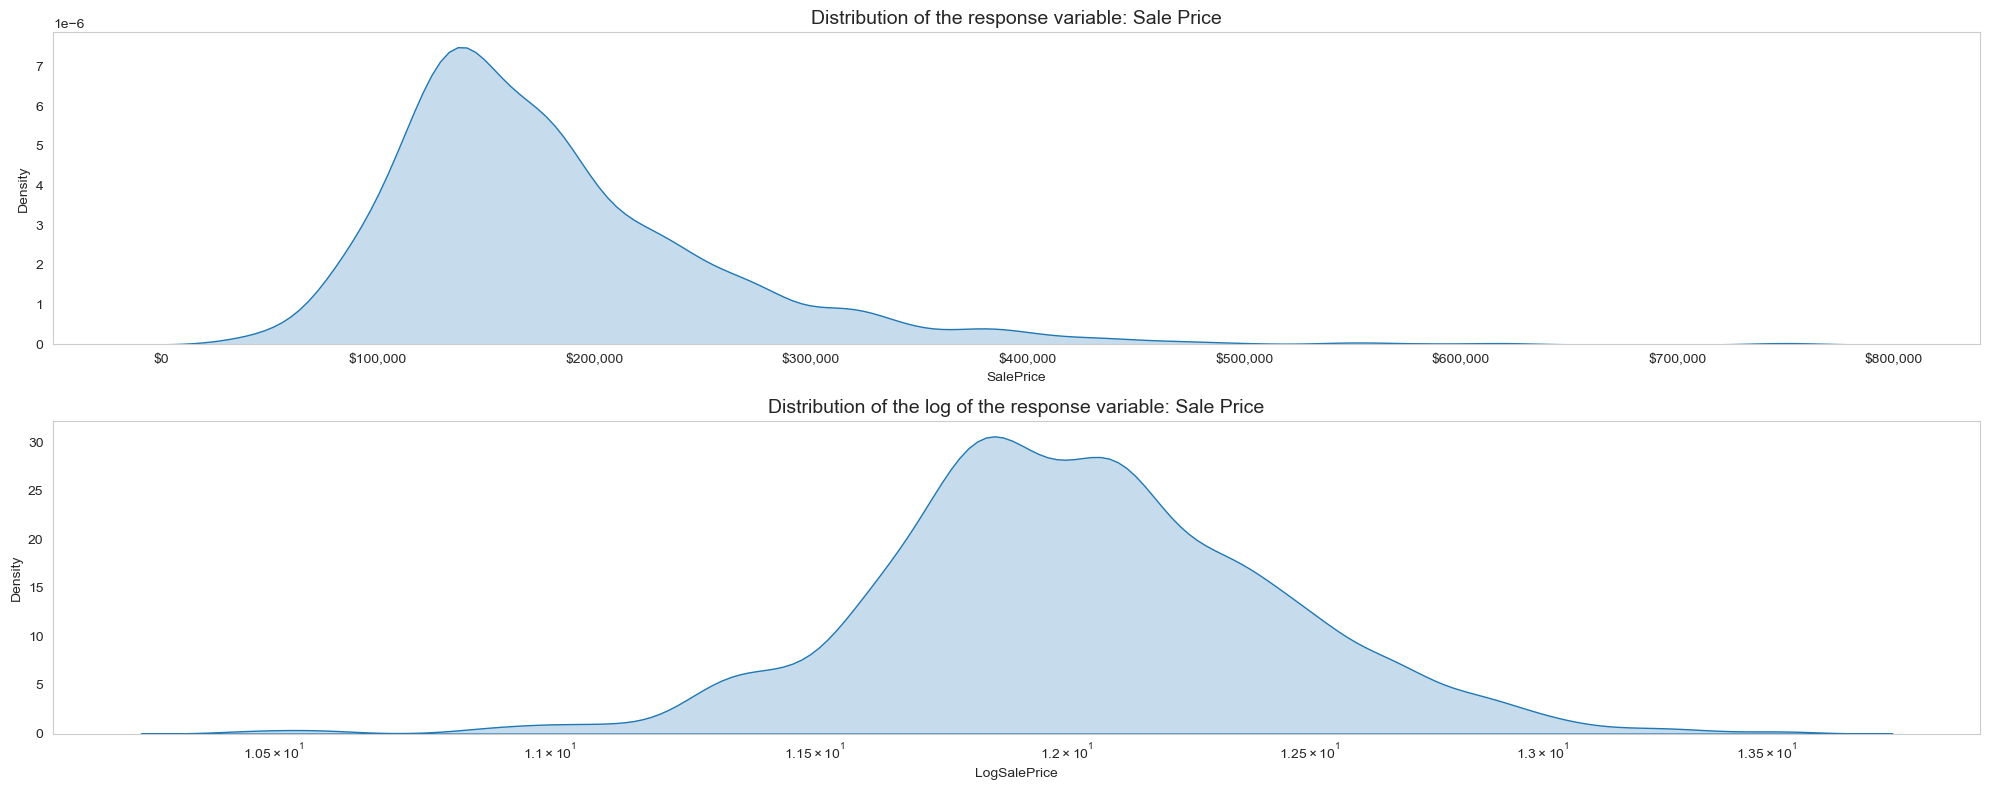

In [50]:
train_log = train.copy()
train_log['LogSalePrice'] = np.log(train_log['SalePrice'])

fig, ax = plt.subplots(2, 1, figsize=(20, 8))
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(ax=ax[0], data=train, x="SalePrice", bw_adjust=.8, fill=True)\
    .set_title("Distribution of the response variable: Sale Price", size=14)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax[0].xaxis.set_major_formatter(tick)

sns.kdeplot(ax=ax[1], data=train_log, x="LogSalePrice", bw_adjust=.8, fill=True, log_scale=True)\
    .set_title("Distribution of the log of the response variable: Sale Price", size=14)

ax[1].xaxis.set_major_formatter(tick)

fig.tight_layout()

The plot below shows the variables that have a correlation above 0.7 with at least one other variable. Many variables are highly correlated with Sale Price such as square feet variables, year built, the number of bedrooms above ground, and garage size. 

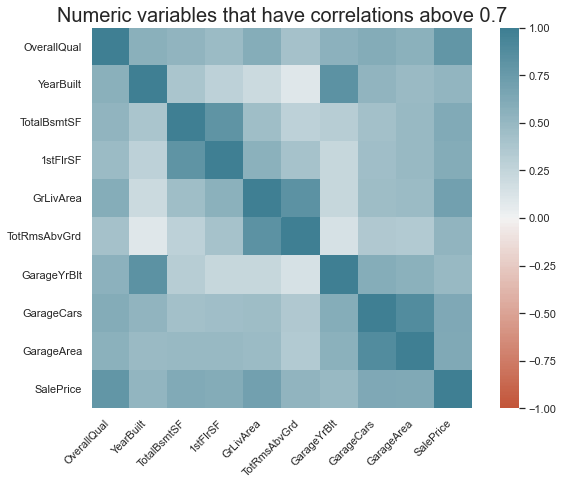

In [26]:
# get correlations of all numeric vars
corr_orig = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above some threshold
threshold = .7
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (np.abs(corr_orig.iloc[i,:]) > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
sns.set()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric variables that have correlations above {:.1f}".format(threshold), fontdict = {"fontsize": 20})

plt.gcf().set_size_inches(10, 7)
fig.tight_layout()
print("")

The grid below shows every numeric feature's relationship to the Sale Price. Like the correlation plot above confirms, several variables that represent the square footage of the home have a clear positive relationship with Sale Price. The overall quality of the home also appears to have a strong positive relationship. 

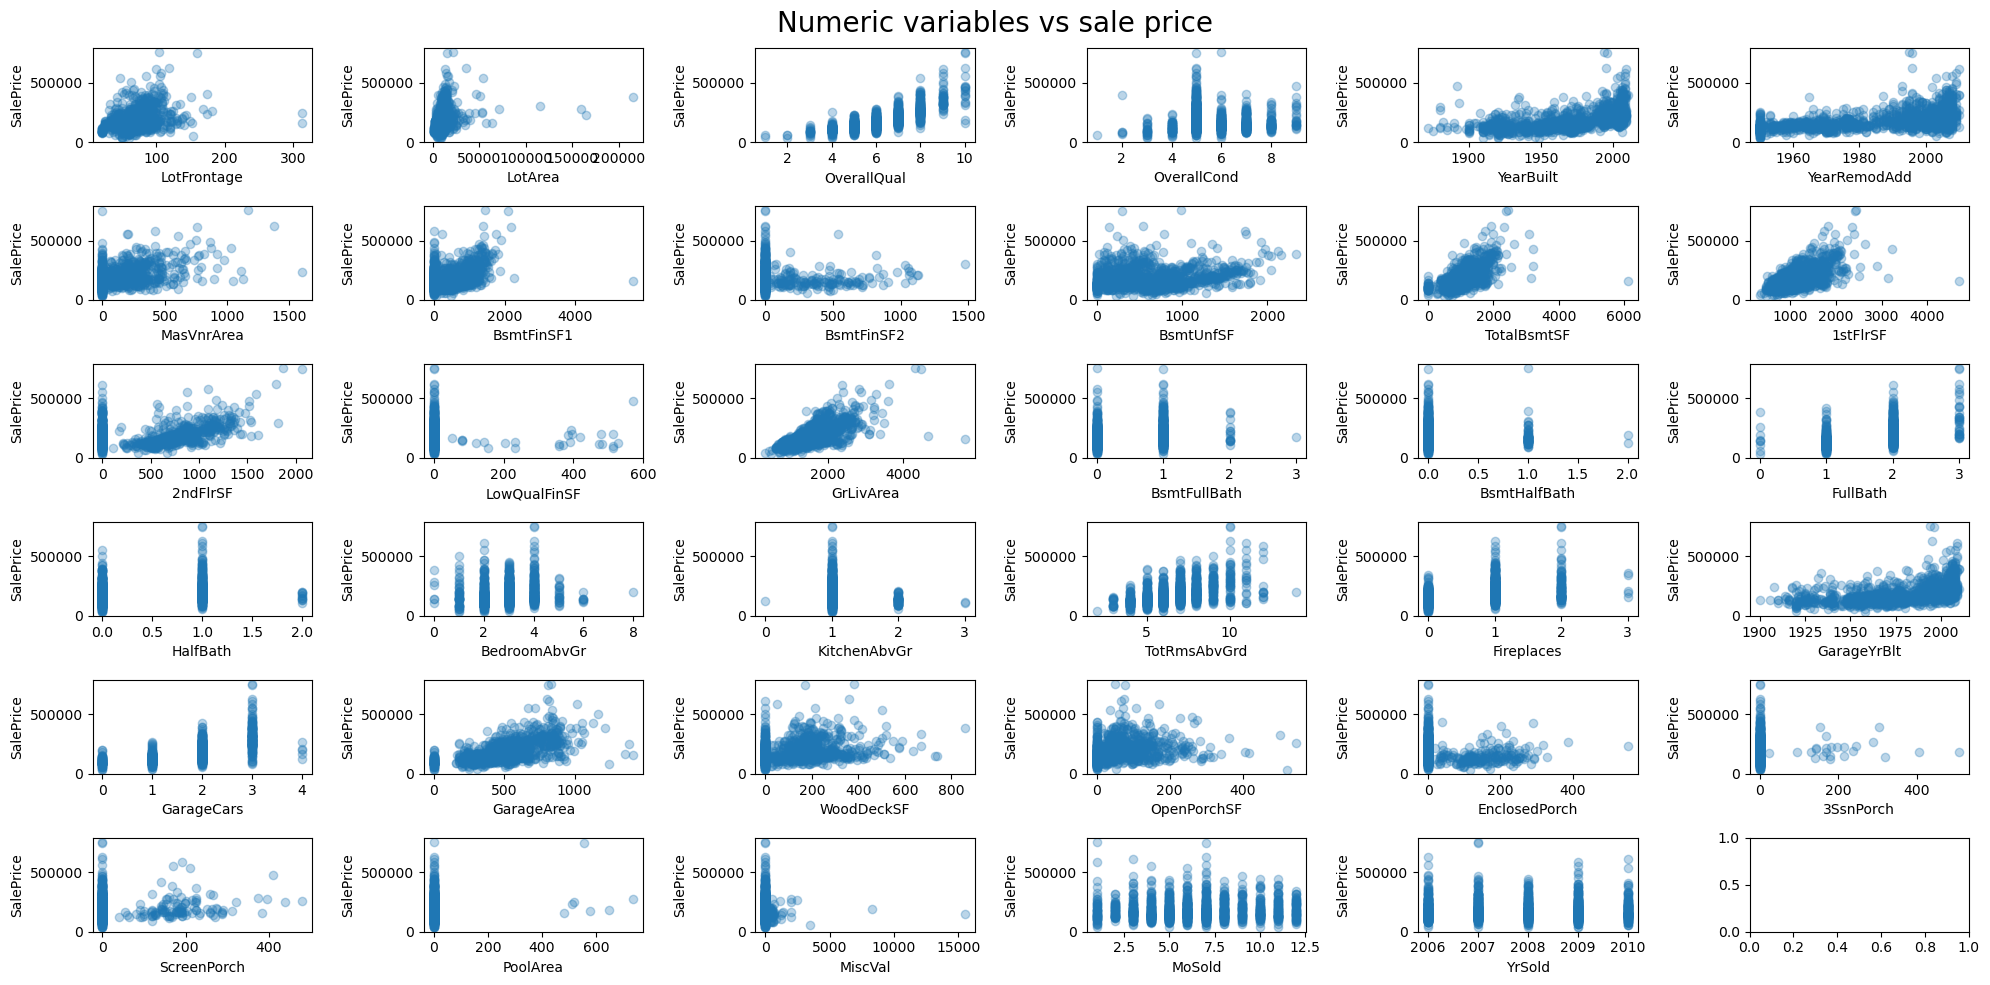

In [36]:
# create dataset for plotting
plot_df = train.drop(columns = ["PoolQC", "MiscFeature", "Id"])
plot_df['MSSubClass'] = plot_df['MSSubClass'].astype('object')

# scatter plots of all num vars w/ response var
num_vars = plot_df.select_dtypes(include=['float', 'int'])

# plot in 6x6 grid to plot the 36 num vars against SalePrice
num_rows = 6
num_cols = 6
plt.style.use('default')
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        if (num_vars.columns[col_i] == "SalePrice"):
            pass 
        else:
            ax[i][j].scatter(num_vars.iloc[:, col_i], num_vars['SalePrice'], alpha = .3)
            ax[i][j].set_xlabel(num_vars.columns[col_i])
            ax[i][j].set_ylabel("SalePrice")
            
            col_i += 1

fig.suptitle("Numeric variables vs sale price".format(col_i), size=20)
fig.tight_layout()
print("")

The next grid shows every categorical feature's relationship to the Sale Price of the home. Each bar shows the average sale price for each factor level of the categorical feature. Several features provide a lot of separation of Sale Price such as MSZoning, neighborhood, condition 1 & 2, and quality variables. 

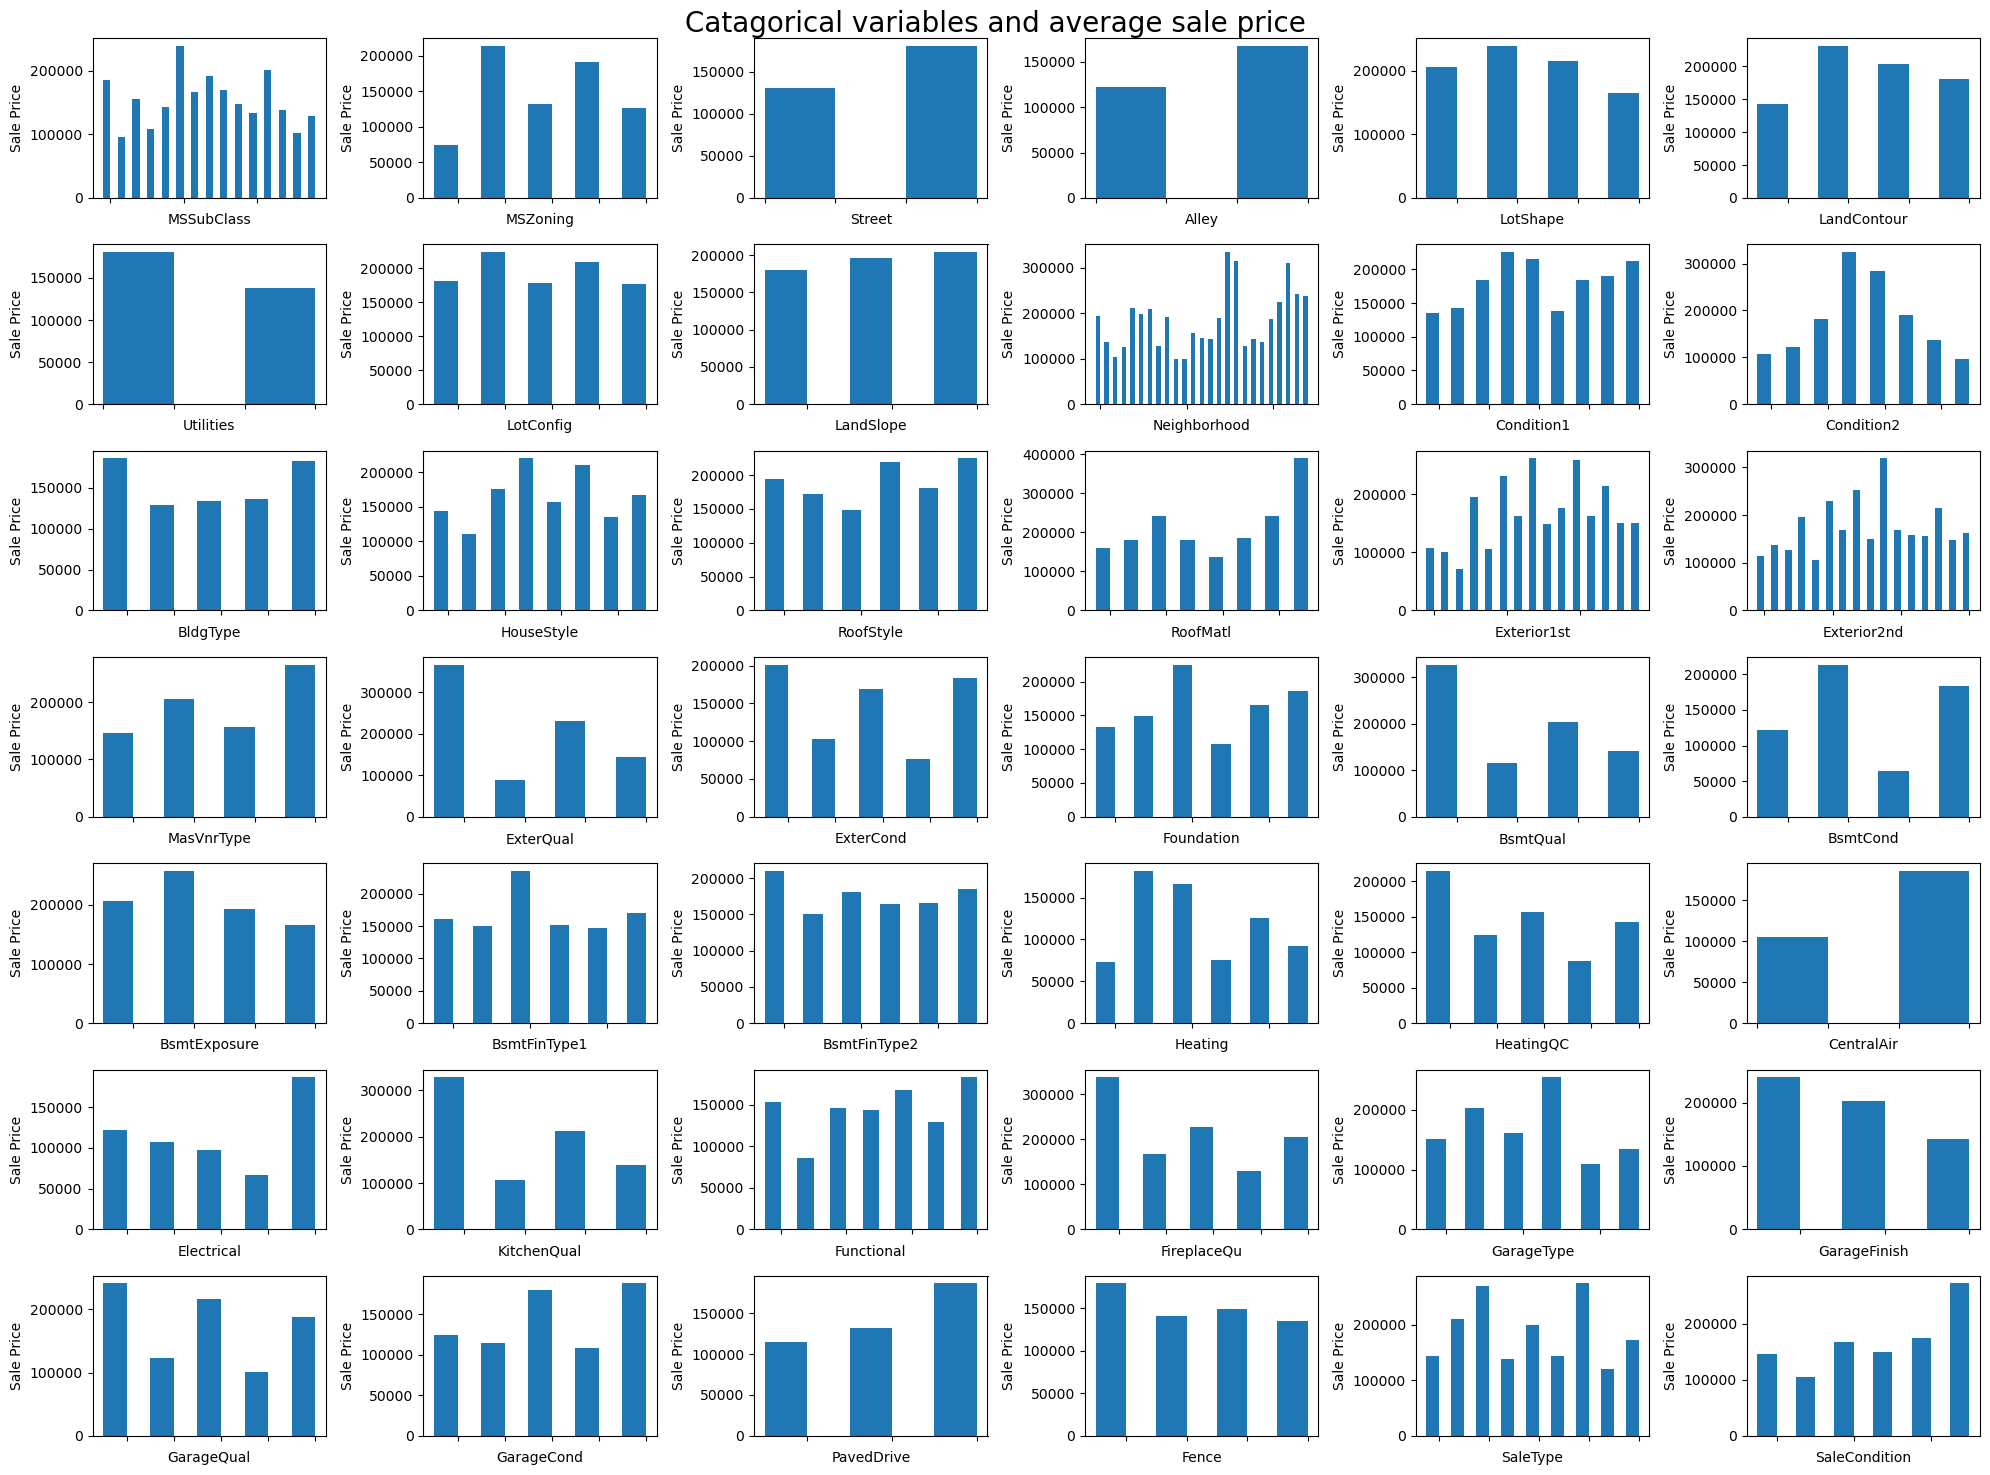

In [41]:
# categorical exploration
cat_vars = pd.concat([plot_df.select_dtypes("object"), train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 7
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 15))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        if var_i == "SalePrice":
            pass 
        else:

            df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1

fig.suptitle("Catagorical variables and average sale price", size=20)
fig.tight_layout()

print("")

The histogram below shows the distribution of the home sale price divided by lot area. Most houses are priced between \$10 and \$30 per square foot of lot area. 

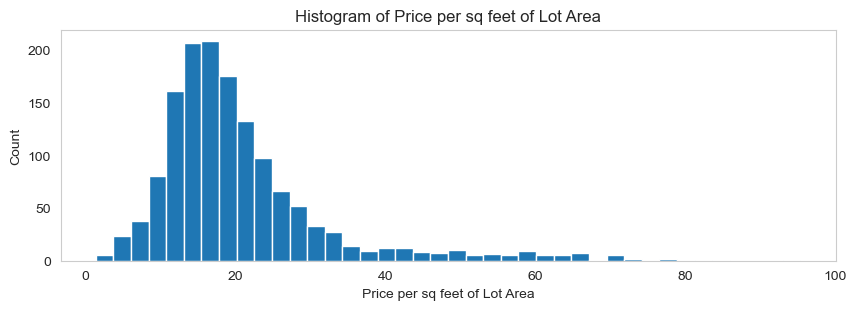

In [65]:
# Looking at price per sq feet of lot area
plot_df.PricePerSqFeet = plot_df.SalePrice/train.LotArea

fig, ax = plt.subplots(figsize = (10, 3))

ax.hist(plot_df.PricePerSqFeet, bins = 40, edgecolor = "white")
ax.set_ylabel('Count')
ax.set_xlabel('Price per sq feet of Lot Area')
ax.set_title('Histogram of Price per sq feet of Lot Area')
print("")

## Conclusion

Scoring the output of our final model on Kaggle, we received an RMSE of 0.12328. Kaggle uses a 2-month rolling leaderboard for this open competition, and this score put us into a position of 654 out of 4917 active competitors.  Based on that ranking, we feel that while we have created a strong model, there is clearly some room for improvement.  

The process highlighted some very important steps for creating a model that performs well on this type of complex data set.  

* For one, it is important to have a good understanding of the data itself.  A thorough EDA allowed us to understand and eliminate variables with a strong colinearity.  It also allowed us to transform variables into something more useful, such as aggregating all of the square footage values, or simple log transformations for a more normal distribution. We spent a lot of time exploring which variables led to valuable insights into the dat.  Some were surprising, such as a subjective measure like Overall Quality.  

* Second, we went down a lot of paths that ended up not bearing fruit.  For example, we explored pre-modeling the neighborhoods into various divisions of expensive and inexpensive, but were unable to get this to lead to any measurable improvement ino the final result.  We also toyed with a lot of data transformations that were ultimately ineffective. However, the explorations were necessary and worthwhile since we needed to answer those questions to move forward.  

* There were many iterations of fine-tuning the final ensemble model with the right weights of each model.  In our experience the right balance was not intuitive, and really just came down to a lot of trial-and-error.  However, this trial-and-error process did ultimately make some of our most significant gains in performance as we narrowed down to our final RMSE score.


[not complete yet]